In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import pyarrow.parquet as pq
from src.datasets.pose_triplet_dataset import PoseTripletDataset, collate_triplets
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [35]:

# === Hyperparameters ===
EMBED_DIM = 3
HIDDEN_DIM = 256
BATCH_SIZE = 4
LR = 1e-3


# === Model ===
class PoseGRUEncoder(nn.Module):
    def __init__(self, input_dim=34, hidden_dim=HIDDEN_DIM, embed_dim=EMBED_DIM):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, embed_dim)

    def forward(self, x, lengths):
        B, T, J, C = x.shape  # [B, T, 17, 2]
        x = x.view(B, T, J * C)  # flatten keypoints: [B, T, 34]
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        _, h_n = self.gru(packed)  # h_n: [2, B, H]
        h = torch.cat([h_n[0], h_n[1]], dim=1)  # [B, 2H]
        emb = F.normalize(self.fc(h), dim=1)  # [B, D]
        return emb
    
class PoseGRUHybrid(nn.Module):
    def __init__(self, embed_dim=3, num_classes=3):
        super().__init__()
        self.encoder = PoseGRUEncoder(embed_dim=embed_dim)  # same GRU block
        self.fc_cls = nn.Linear(embed_dim, num_classes)     # new classifier

    def forward(self, x, lengths):
        emb = self.encoder(x, lengths)                      # (B, D)
        logits = self.fc_cls(emb)                           # (B, C)
        return emb, logits

In [36]:
EPOCHS = 20

table = pq.read_table("../data/poses/all_fighters.parquet")
dataset = PoseTripletDataset(table)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_triplets)

model = PoseGRUHybrid(embed_dim=3, num_classes=3)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

triplet_loss = torch.nn.TripletMarginLoss(margin=0.3)
ce_loss = torch.nn.CrossEntropyLoss()
alpha = 0.5  # weighting for triplet loss

model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch in loader:
        anchor, positive, negative = batch["anchor"], batch["positive"], batch["negative"]
        lengths = batch["lengths"]
        labels = batch["labels"]

        optimizer.zero_grad()
        emb_a, logits = model(anchor, lengths)
        emb_p, _ = model(positive, lengths)
        emb_n, _ = model(negative, lengths)

        # --- Loss ---
        loss_cls = ce_loss(logits, labels)
        loss_trip = triplet_loss(emb_a, emb_p, emb_n)
        loss = loss_cls + alpha * loss_trip

        # --- Backward ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}")


Epoch 1/20 - Loss: 1.3003
Epoch 2/20 - Loss: 1.1590
Epoch 3/20 - Loss: 1.2445
Epoch 4/20 - Loss: 1.3877
Epoch 5/20 - Loss: 1.0931
Epoch 6/20 - Loss: 1.1400
Epoch 7/20 - Loss: 1.2051
Epoch 8/20 - Loss: 1.1484
Epoch 9/20 - Loss: 1.1257
Epoch 10/20 - Loss: 1.0329
Epoch 11/20 - Loss: 1.3890
Epoch 12/20 - Loss: 1.1179
Epoch 13/20 - Loss: 1.1327
Epoch 14/20 - Loss: 1.0187
Epoch 15/20 - Loss: 1.0345
Epoch 16/20 - Loss: 0.9741
Epoch 17/20 - Loss: 1.0433
Epoch 18/20 - Loss: 1.0067
Epoch 19/20 - Loss: 0.8583
Epoch 20/20 - Loss: 1.0657


In [38]:
all_embeddings = []
labels = []

with torch.no_grad():
    for item in dataset.data:
        pose = item["pose"].unsqueeze(0)  # (1, T, 17, 2)
        length = torch.tensor([item["length"]])
        emb, _ = model(pose, length)  # (1, D)
        all_embeddings.append(emb.squeeze(0).numpy())
        labels.append(item["fighter"])  # fighter name

embeddings = np.stack(all_embeddings)

In [39]:
embeddings

array([[-0.6741201 ,  0.15783532,  0.7215608 ],
       [-0.45931664,  0.37324858,  0.8060483 ],
       [-0.51305217,  0.04657256,  0.857093  ],
       [-0.5289487 ,  0.21763967,  0.82027197],
       [-0.49174407,  0.3664272 ,  0.7898854 ],
       [ 0.43764985,  0.30467504, -0.8459525 ],
       [ 0.5670563 , -0.6574791 ,  0.49615362],
       [ 0.71762395, -0.6643388 ,  0.208973  ],
       [ 0.50310767, -0.81760496,  0.28000852],
       [ 0.52515495,  0.02727149, -0.8505696 ],
       [ 0.5824544 , -0.64576477,  0.493695  ],
       [-0.20780683, -0.3876995 ,  0.89805645],
       [ 0.68031406, -0.04659981, -0.73143786],
       [-0.7583209 ,  0.5486937 ,  0.3519725 ],
       [ 0.7574326 , -0.5119933 , -0.40516508]], dtype=float32)

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=5, random_state=42)
emb_3d = tsne.fit_transform(embeddings)

/var/folders/m6/40k0v17n0xn74zsggnhf227w0000gn/T/ipykernel_1230/2378894913.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


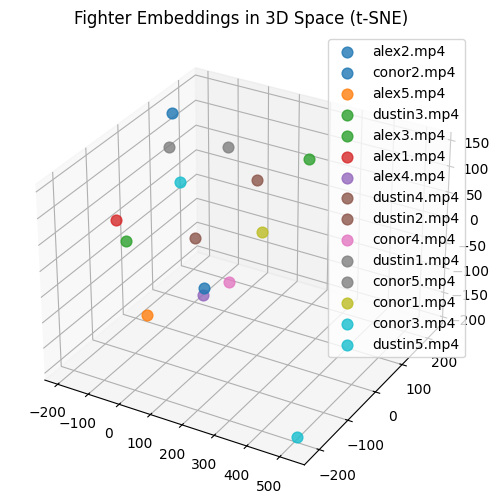

In [25]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

unique_labels = list(set(labels))
colors = plt.cm.get_cmap("tab10", len(unique_labels))

for i, label in enumerate(unique_labels):
    idxs = [j for j, l in enumerate(labels) if l == label]
    ax.scatter(*emb_3d[idxs].T, label=label, alpha=0.8, s=60, color=colors(i))

ax.legend()
plt.title("Fighter Embeddings in 3D Space (t-SNE)")
plt.show()


/var/folders/m6/40k0v17n0xn74zsggnhf227w0000gn/T/ipykernel_1230/2555137688.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


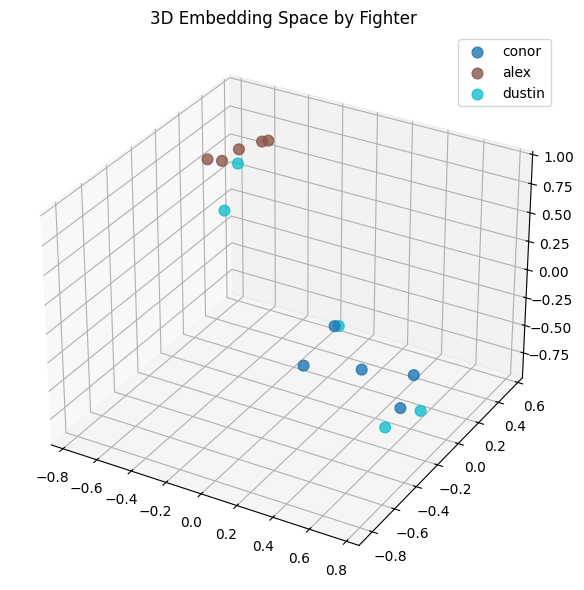

In [40]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

unique_labels = list(set(labels))
colors = plt.cm.get_cmap("tab10", len(unique_labels))

for i, label in enumerate(unique_labels):
    idxs = [j for j, l in enumerate(labels) if l == label]
    ax.scatter(*embeddings[idxs].T, label=label, color=colors(i), alpha=0.8, s=60)

ax.set_title("3D Embedding Space by Fighter")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PoseGRUEncoder(embed_dim=3, num_classes=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

triplet_loss = torch.nn.TripletMarginLoss(margin=0.3)
ce_loss = torch.nn.CrossEntropyLoss()
alpha = 0.5  # weighting for triplet loss

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        anchor = batch["anchor"].to(device)     # (B, T, 17, 2)
        positive = batch["positive"].to(device)
        negative = batch["negative"].to(device)
        lengths = batch["lengths"].to(device)
        labels = batch["labels"].to(device)      # (B,)

        # --- Forward ---
        emb_a, logits = model(anchor, lengths)
        emb_p, _ = model(positive, lengths)
        emb_n, _ = model(negative, lengths)

        # --- Loss ---
        loss_cls = ce_loss(logits, labels)
        loss_trip = triplet_loss(emb_a, emb_p, emb_n)
        loss = loss_cls + alpha * loss_trip

        # --- Backward ---
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"✅ Epoch {epoch+1}: Loss = {avg_loss:.4f}")
